In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

In [40]:
# Problem parameters:
a = dde.Variable(1.0)  # Thermal diffusivity, trainable parameter, initial value of 1.0

L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def funn(x, t):
    return np.exp(-(np.pi**2 * 0.4 * t) / (L**2)) * np.cos(np.pi * x / L)

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

observe_x = np.vstack((np.linspace(-1, 1, num=10), np.linspace(-1, 1, num=10))).T
observe_y = dde.icbc.PointSetBC(observe_x, funn(observe_x[:, 0:1], observe_x[:, 1:]), component=0)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    anchors=observe_x,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, external_trainable_variables=a
)

Compiling model...
'compile' took 0.001502 s



Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.76e-02, 9.30e-02, 6.53e-01]    [1.71e-02, 9.30e-02, 6.53e-01]    []  
0 [1.00e+00]
1000      [6.41e-04, 1.97e-05, 4.15e-06]    [1.73e-04, 1.97e-05, 4.15e-06]    []  
2000      [1.08e-04, 1.87e-05, 2.11e-05]    [4.91e-05, 1.87e-05, 2.11e-05]    []  
2000 [2.45e-01]
3000      [3.65e-05, 3.38e-06, 4.29e-07]    [2.13e-05, 3.38e-06, 4.29e-07]    []  
4000      [1.82e-05, 2.29e-06, 2.06e-07]    [1.10e-05, 2.29e-06, 2.06e-07]    []  
4000 [2.15e-01]
5000      [1.11e-05, 1.78e-06, 1.88e-07]    [6.91e-06, 1.78e-06, 1.88e-07]    []  
6000      [7.84e-06, 1.65e-06, 1.65e-07]    [5.08e-06, 1.65e-06, 1.65e-07]    []  
6000 [2.01e-01]
7000      [1.42e-05, 6.53e-05, 1.33e-04]    [9.27e-06, 6.53e-05, 1.33e-04]    []  
8000      [4.96e-06, 1.26e-06, 1.17e-06]    [3.24e-06, 1.26e-06, 1.17e-06]    []  
8000 [1.92e-01]
9000      [4.13e-06, 8.54e-07, 1.61e-07]    [2.69e-06, 8.54e-07, 1.

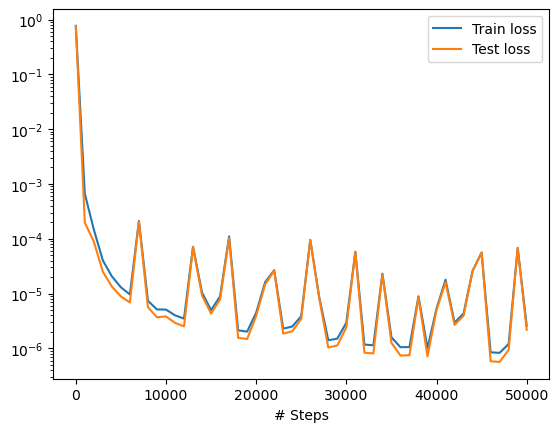

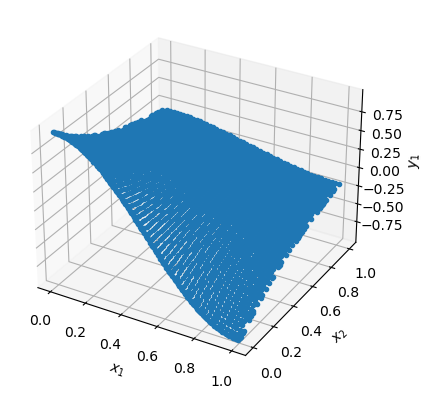

In [41]:
variable = dde.callbacks.VariableValue(a, period=2000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [42]:
a

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.17003393>